In [1]:
import torch
import numpy as np
import os
import sys

src_path = os.path.abspath(os.path.join("..","src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print(sys.path)

['/nethome/abhalerao9/TIMESERIESMODELING/TSFMProject/src', '/nethome/abhalerao9/anaconda3/envs/timesfm/lib/python311.zip', '/nethome/abhalerao9/anaconda3/envs/timesfm/lib/python3.11', '/nethome/abhalerao9/anaconda3/envs/timesfm/lib/python3.11/lib-dynload', '', '/nethome/abhalerao9/anaconda3/envs/timesfm/lib/python3.11/site-packages']


In [2]:
from tsfmproject.dataset import MoiraiDataset
from tsfmproject.model import MoiraiTSModel
from tsfmproject.visualization import ForecastVisualization

/nethome/abhalerao9/anaconda3/envs/timesfm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_dataset = MoiraiDataset(name="ett", mode="train", path='/nethome/sli999/TSFMProject/src/tsfmproject/models/moment/data/ETTh1.csv', datetime_col='date', freq='h', context_len=128, horizon_len=64)
test_dataset = MoiraiDataset(name="ett", mode="test", path='/nethome/sli999/TSFMProject/src/tsfmproject/models/moment/data/ETTh1.csv', datetime_col='date', freq='h', context_len=128, horizon_len=64)



In [4]:
config = {
    "context_len": 128,
    "horizon_len": 64,
}
model_type = "moirai-moe"
model_size = "small"
moirai_model = MoiraiTSModel(model_type=model_type, model_size=model_size, config=config)

In [5]:
print(moirai_model.model.device)

cuda:0


In [6]:
eval_results, trues, preds, histories = moirai_model.evaluate(test_dataset, metrics=["MSE", "MASE"])

In [7]:
print(eval_results)

{'MSE': 0.557750582893142, 'MASE': 2.109115778548502}


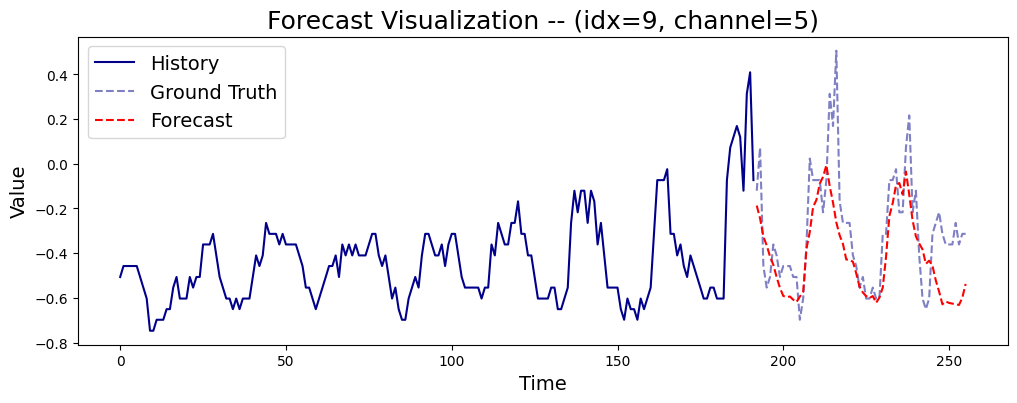

In [11]:
visualization = ForecastVisualization(trues, preds, histories)
visualization.plot(channel_idx=5, time_idx=9, crop_history=True)